## Introduction

The data in the file is downloaded automatically by **WebDriver** from **https://infoshare.stats.govt.nz**.

The data includes:
- Labour force status data (unemployment rate)

In [1]:
#install.packages(c("RSelenium", "writexl"))
#install.packages("here")

In [2]:
# install.packages(c("RSelenium", "writexl", "here"))

# CPI data
library(magrittr)
library(polite)
library(rvest)
library(here)
library(RSelenium)

here() starts at /Users/zhoujinze/Documents/DataScience/ds-assessment/DATA-422/group project/data422-group-project



In [3]:
data_dir = paste(here(), "data", sep = "/")

# session <- bow(
#     "https://www.rbnz.govt.nz/-/media/e3420ae9ec24421bac870e70660d20d0.ashx",
#     user_agent = "polite R package",
#     delay = 5,
#     times = 3,
#     force = FALSE,
#     verbose = FALSE
# )

# rip(session, 
#    destfile = "CPI.xlsx",
#    path = data_dir
#)

eCaps <- list(
  chromeOptions = 
    list(prefs = list(
        "profile.default_content_settings.popups" = 0L,
        "download.prompt_for_download" = FALSE,
        "directory_upgrade" = TRUE,
        "download.default_directory" = data_dir),
      args = list(
        "--disable-blink-features=AutomationControlled"
      )),
      useAutomationExtension = FALSE,
      excludeSwitches = list(
        "enable-automation"
      )
)

rD <- rsDriver(verbose = FALSE, browser = "chrome", chromever = "106.0.5249.61",
                extraCapabilities = eCaps)
remDr <- rD$client
remDr$maxWindowSize()
remDr$navigate("https://infoshare.stats.govt.nz/infoshare/Default.aspx")
# remDr$screenshot(display = TRUE)

# webElem <- remDr$findElement(using = "css", "[data-ga-action='hm1.xlsx'] button")


In [4]:
# Wrapper of remoteDriver$findElement, enable wait and check for 3 times
# rmd:  remote driver client
# p_using: `using` param of findElement
# p_value: `value` param of findElement
get_tree_element <- function(rmd, p_using, p_value) {
    sleep_secs = 2
    vis_check = 0

    # wait for progress valid
    Sys.sleep(sleep_secs)
    while (sleep_secs < 10 & vis_check < 30) {
        vis = remDr$executeScript("return document.getElementById(arguments[0]).style.visibility",
                            args = list("ctl00_MainContent_goProgress", ""))
        # wait for progress finish
        if (vis == "visible") {
            # in progress, keep wait
            vis_check = vis_check + 1
            sleep_secs = 2
            Sys.sleep(sleep_secs)
            next
        } else {
            # wait for element load
           Sys.sleep(sleep_secs) 
        }
        
        try(suppressMessages(rmd$findElement(using = p_using, value = p_value)), silent = TRUE)
        if (rmd$status == 0) {
            elem = rmd$findElement(using = p_using, value = p_value)
            return(elem)
        } else if (remDr$status == 7) {
            # wait for 2 seconds
            Sys.sleep(sleep_secs)
        }
        sleep_secs = sleep_secs * 2
    }
    return(NULL)
}

get_element <- function(rmd, p_using, p_value) {
    sleep_secs = 2

    # wait for progress valid
    Sys.sleep(sleep_secs)
    while (sleep_secs < 10) {
        try(suppressMessages(rmd$findElement(using = p_using, value = p_value)), silent = TRUE)
        if (rmd$status == 0) {
            elem = rmd$findElement(using = p_using, value = p_value)
            return(elem)
        } else if (remDr$status == 7) {
            # wait for 2 seconds
            Sys.sleep(sleep_secs)
        }
        sleep_secs = sleep_secs * 2
    }
    return(NULL)
}

In [5]:
# navigate into the labour data select panel
elem_lv_one = get_tree_element(remDr, "link text", "Work income and spending")
elem_lv_one$clickElement()

# wait for loading
elem_lv_two = get_tree_element(remDr, "link text",  "Household Labour Force Survey - HLF")
elem_lv_two$clickElement()

elem_lv_three = get_tree_element(remDr, "link text", "Labour Force Status for people aged 15 to 64 years: Seasonally Adjusted (Qrtly-Mar/Jun/Sep/Dec)")
elem_lv_three$clickElement()

In [6]:
# setup options of labour data for extract data
season_adj  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl02_lblSelectAll")
time_range  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl07_lblSelectAll")
obs_range  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl04_lblSelectAll")
submit  = get_element(remDr, "css selector", "input#ctl00_MainContent_btnGo")

season_adj$clickElement()
time_range$clickElement()
obs_range$clickElement()
submit$clickElement()
# get footnotes for finishing page loading
foot = get_element(remDr, "link text", "Footnotes")

page_source = remDr$getPageSource()[[1]]

In [7]:
# parse the page source
doc = xml2::read_html(page_source)
labour_table = doc %>% html_table()

## Data Wrangling & Save

date   Persons Employed in Labour Force Persons Unemployed in Labour Force
1  1986Q1 1,594                            70                                
2  1986Q2 1,592                            69                                
3  1986Q3 1,590                            70                                
4  1986Q4 1,581                            71                                
5  1987Q1 1,597                            69                                
6  1987Q2 1,598                            70                                
7  1987Q3 1,599                            70                                
8  1987Q4 1,590                            74                                
9  1988Q1 1,570                            83                                
10 1988Q2 1,557                            91                                
   Not in Labour Force Working Age Population Labour Force Participation Rate
1  536                 2,200                  75.6                           
2  541                 2,202                  75.4                           
3  544                 2,204                  75.3                           
4  552                 2,204                  75.0                           
5  546                 2,212                  75.3                           
6  548                 2,216                  75.3                           
7  551                 2,221                  75.2                           
8  556                 2,221                  74.9                           
9  573                 2,226                  74.3                           
10 580                 2,228                  74.0                           
   Unemployment Rate Employment Rate Total Labour Force
1  4.2               72.4            1,664             
2  4.2               72.3            1,661             
3  4.2               72.1            1,660             
4  4.3               71.7            1,652             
5  4.1               72.2            1,666             
6  4.2               72.1            1,668             
7  4.2               72.0            1,670             
8  4.5               71.6            1,665             
9  5.0               70.5            1,653             
10 5.5               69.9            1,648

Warning message:
"`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead."


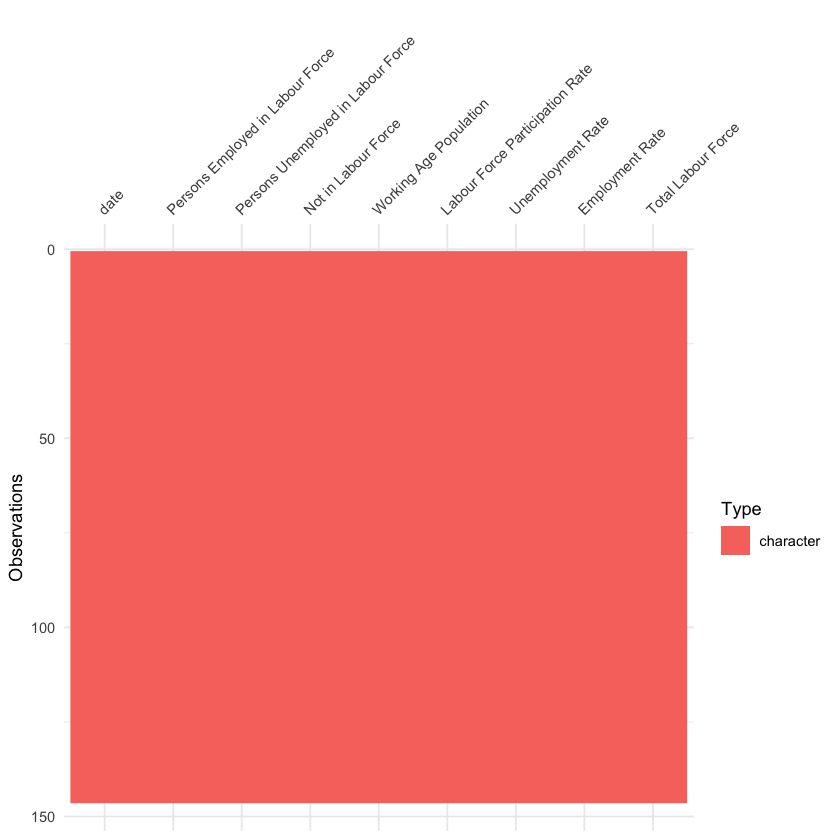

In [8]:
library(visdat)
library("writexl")

# labour data
labour <- labour_table[[8]]
labour[2,1] = "date"
column_name = labour[2,]
colnames(labour) = column_name
labour <- labour[-c(1,2),]
labour %>% head(10)

vis_dat(labour)

In [9]:

write_xlsx(labour, paste(data_dir, "labour_force_status.xlsx", sep = "/"))